```
From: https://github.com/ksatola
Version: 0.0.5
```

# Model - PM2.5 - Machine Learning Modelling - Regression

## Contents

- [Machine Learning Regression](#mlr)
- Hourly prediction
    - [Load hourly data](#data_h)
    - [Base Modelling](#model_h)
    - [Hyper-parameters Tuning](#model_h_tune)
- Daily prediction
    - [Load daily data](#data_d)
    - [Modelling](#model_d)
    - [Hyper-parameters Tuning](#model_d_tune)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score

In [6]:
#from model import (
    #get_ensemble_models_for_regression,
    #get_analytical_view_for_meta_model,
    #fit_base_models,
    #fit_meta_model,
    #evaluate_models,
    #predict_with_super_learner
#)

from model import (
    get_pm25_data_for_modelling,
    split_df_for_ml_modelling,
    get_models_for_regression
)

from measure import (
    #get_rmse
    score_ml_models
)

#from plot import (
    #plot_train_test_predicted,
#    plot_observed_vs_predicted,
#    plot_observations_to_predictions_relationship,
    #fit_theoretical_dist_and_plot
#)

---
<a id='mlr'></a>

## Machine Learning Regression

XXXXXXXXX

- Linear Algorithms: Logistic Regression.
- Nonlinear Algorithms: Classification and Regression Trees (CART), Support Vector Machines (SVM), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

Napisac z scikit learn wstep do regresji

wypisac funkcje - zob. ponizej

Hyper based on CV and training data
Final check based on test data - TODO

w pracy opisac generalne podejscie do ML, proste, dla najlepszych hyper, i dla nich super learner

XXXX
<img src="images/super_learner_algorithm_flow_diagram.png" style="width: 800px;"/>
From https://www.degruyter.com/view/journals/sagmb/6/1/article-sagmb.2007.6.1.1309.xml.xml


score models na zbiorze testowym!
zrobic final test wybranych modeli ML na zbiorze testowym i policzyc RMSE -> symulacja predykcji
jesli linear regression jest najlepsze to sprawdzic OLS assumptions dla zbioru danych

---
<a id='data_h'></a>

## Load hourly data

In [92]:
dfh = get_pm25_data_for_modelling('ml', 'h')
dfh.head()

common.py | 42 | get_pm25_data_for_modelling | 04-Jun-20 23:04:52 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_ml_24hours_lags.hdf
common.py | 43 | get_pm25_data_for_modelling | 04-Jun-20 23:04:52 | INFO: Dataframe size: (96378, 19)


,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
0,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,14.019144,20.936157,23.611710,28.537801,1,1,11,1,1,1,1,1
1,-25.839649,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,14.019144,20.936157,23.611710,1,1,12,1,1,1,1,1
2,-16.761822,-25.839649,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,14.019144,20.936157,1,1,13,1,1,1,1,1
3,-6.697300,-16.761822,-25.839649,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,14.019144,1,1,14,1,1,1,1,1
4,-2.515568,-6.697300,-16.761822,-25.839649,-18.246170,-13.443917,0.156504,9.915600,10.136910,13.456166,14.163808,1,1,15,1,1,1,1,1


In [93]:
# Limit training data to 2 last years of hourly data (for performance reasons)
df = dfh[-365*24:]
df.shape

(8760, 19)

In [94]:
df.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
87618,26.797137,-23.627303,-11.066157,-6.896479,-21.893212,-29.155953,-37.303764,-20.646928,-30.484597,-29.887483,-38.440042,1,1,1,1,1,0,1,1
87619,21.497168,26.797137,-23.627303,-11.066157,-6.896479,-21.893212,-29.155953,-37.303764,-20.646928,-30.484597,-29.887483,1,1,2,1,1,0,1,1
87620,29.507759,21.497168,26.797137,-23.627303,-11.066157,-6.896479,-21.893212,-29.155953,-37.303764,-20.646928,-30.484597,1,1,3,1,1,0,1,1
87621,16.637266,29.507759,21.497168,26.797137,-23.627303,-11.066157,-6.896479,-21.893212,-29.155953,-37.303764,-20.646928,1,1,4,1,1,0,1,1
87622,17.504926,16.637266,29.507759,21.497168,26.797137,-23.627303,-11.066157,-6.896479,-21.893212,-29.155953,-37.303764,1,1,5,1,1,0,1,1


---
<a id='model_h'></a>

## Base Modelling

In [95]:
# Train test split
X_train, X_test, y_train, y_test = split_df_for_ml_modelling(data=df, 
                                                             target_col='t', 
                                                             train_size=0.02) # train_size=0.00024

In [96]:
X_train.shape

(8584, 18)

In [97]:
X_test.shape

(176, 18)

In [98]:
# Define regression models in scope
reg_models = get_models_for_regression()
models = []

for model in reg_models:
    item = (type(model).__name__, model)
    models.append(item)
    print(item)

('LinearRegression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))
('ElasticNet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False))
('SVR', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))
('DecisionTreeRegressor', DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'))
('KNeighborsRegressor', KNeighborsRegressor(algorithm='auto', leaf_siz

In [99]:
%%time
# Perform initial ranking
scores, results, names = score_ml_models(X_train=X_train,
                                         y_train=y_train,
                                         models=models,
                                         n_splits = 5,
                                         metric='neg_root_mean_squared_error',
                                         metric_label="RMSE", 
                                         seed=123)
for score in scores:
    print(score)

LinearRegression, RMSE 5.56711818313286, (std. dev. 0.1985876635301725)
ElasticNet, RMSE 5.570228808723629, (std. dev. 0.18766919576955177)
SVR, RMSE 7.182387115542616, (std. dev. 0.16268675420669534)
DecisionTreeRegressor, RMSE 7.873690915369804, (std. dev. 0.27778285055964064)
KNeighborsRegressor, RMSE 6.653434322953375, (std. dev. 0.3006601773427491)
AdaBoostRegressor, RMSE 6.429824450932732, (std. dev. 0.10930505848320025)
BaggingRegressor, RMSE 5.898093853859504, (std. dev. 0.25298260577679066)
RandomForestRegressor, RMSE 5.8841056604815085, (std. dev. 0.21989443125211608)
ExtraTreesRegressor, RMSE 5.909062322838997, (std. dev. 0.25022463868645484)
CPU times: user 22.3 s, sys: 692 ms, total: 23 s
Wall time: 22.4 s


In [ ]:
LinearRegression, RMSE 5.56711818313286, (std. dev. 0.1985876635301725)
ElasticNet, RMSE 5.570228808723629, (std. dev. 0.18766919576955177)
SVR, RMSE 7.182387115542616, (std. dev. 0.16268675420669534)
DecisionTreeRegressor, RMSE 7.841333664708597, (std. dev. 0.17552023518416768)
KNeighborsRegressor, RMSE 6.653434322953375, (std. dev. 0.3006601773427491)
AdaBoostRegressor, RMSE 6.425082457443115, (std. dev. 0.18253907464994834)
BaggingRegressor, RMSE 5.921852717688901, (std. dev. 0.20225920292760463)
RandomForestRegressor, RMSE 5.939068350982593, (std. dev. 0.2842986689298549)
ExtraTreesRegressor, RMSE 5.858054046678829, (std. dev. 0.2381438572224743)
CPU times: user 21.1 s, sys: 926 ms, total: 22.1 s
Wall time: 21.5 s

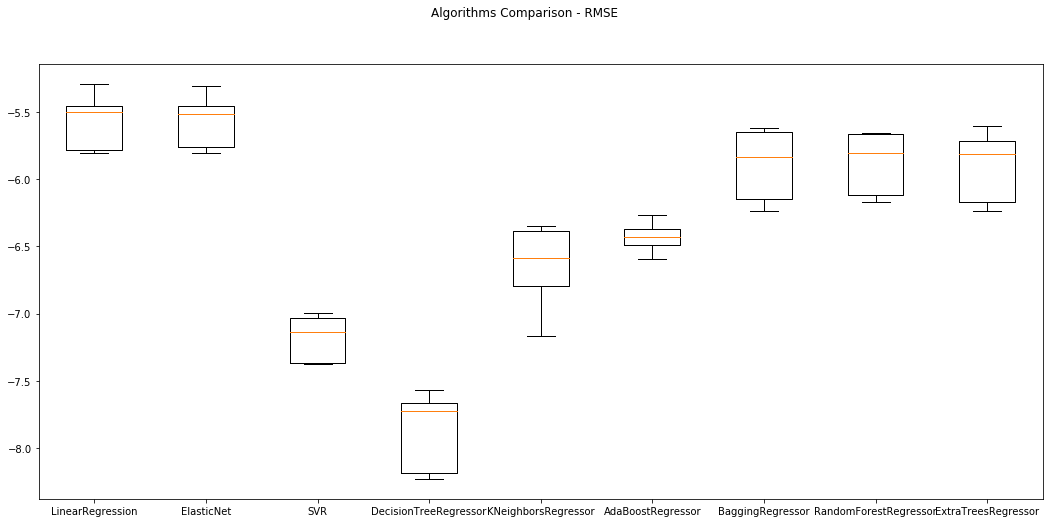

In [100]:
# Compare Algorithms
fig = plt.figure(figsize=(18, 8))
fig.suptitle('Algorithms Comparison - RMSE')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('images/ml_comparison_rmse_h.png')
plt.show();

---
<a id='model_h_tune'></a>

## Hyper-parameter Tuning

`Hyper-parameters` are parameters that are not directly learnt within estimators. It is possible and recommended to search the hyper-parameter space **for the best cross validation score**.

While using a grid of parameter settings is currently the most widely used method for parameter optimization (`GridSearchCV`), other search methods have more favourable properties. `RandomizedSearchCV` implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

- A budget can be chosen independent of the number of parameters and possible values.
- Adding parameters that do not influence the performance does not decrease efficiency.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for `GridSearchCV`. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the n_iter parameter. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified: loguniform(1, 100) can be used instead of [1, 10, 100]. 

-----

## Grid Search: hyper-parameters tuning
https://scikit-learn.org/stable/modules/grid_search.html#grid-search

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

Some models allow for specialized, efficient parameter search strategies, outlined below. Two generic approaches to sampling search candidates are provided in scikit-learn: for given values, GridSearchCV exhaustively considers all parameter combinations, while RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution.

Note that it is common that a small subset of those parameters can have a large impact on the predictive or computation performance of the model while others can be left to their default values. It is recommended to read the docstring of the estimator class to get a finer understanding of their expected behavior, possibly by reading the enclosed reference to the literature.

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

- A budget can be chosen independent of the number of parameters and possible values.

- Adding parameters that do not influence the performance does not decrease efficiency.

## Cross-validation: evaluating estimator performance
https://scikit-learn.org/stable/modules/cross_validation.html

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test.

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using  of the folds as training data;

- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

dac obrazek ze strony, zrobic source: sklearn

## Pipelines and composite estimators
https://scikit-learn.org/stable/modules/compose.html

Transformers are usually combined with classifiers, regressors or other estimators to build a composite estimator. The most common tool is a Pipeline.

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

Convenience and encapsulation
You only have to call fit and predict once on your data to fit a whole sequence of estimators.

Joint parameter selection
You can grid search over parameters of all estimators in the pipeline at once.

Safety
Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).

## Model persistence
https://scikit-learn.org/stable/modules/model_persistence.html

After training a scikit-learn model, it is desirable to have a way to persist the model for future use without having to retrain. The following section gives you an example of how to persist a model with pickle. 

pickle (and joblib by extension), has some issues regarding maintainability and security. Because of this,

- Never unpickle untrusted data as it could lead to malicious code being executed upon loading.

- While models saved using one version of scikit-learn might load in other versions, this is entirely unsupported and inadvisable. It should also be kept in mind that operations performed on such data could give different and unexpected results.

In order to rebuild a similar model with future versions of scikit-learn, additional metadata should be saved along the pickled model:

- The training data, e.g. a reference to an immutable snapshot

- The python source code used to generate the model

- The versions of scikit-learn and its dependencies

- The cross validation score obtained on the training data

- This should make it possible to check that the cross-validation score is in the same range as before.

Since a model internal representation may be different on two different architectures, dumping a model on one architecture and loading it on another architecture is not supported.

more: https://pyvideo.org/pycon-us-2014/pickles-are-for-delis-not-software.html

In [25]:
def perform_grid_search_cv2(X_train, y_train, model, param_grid, scoring, num_folds = 6, seed = 123):

    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, y_train)

    means = grid_result.cv_results_['mean_test_score'] 
    stds = grid_result.cv_results_['std_test_score'] 
    params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
        #print("{:0.2f} ({:0.2f}) with: {}".format(mean, stdev, param))
    #print('-------')
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

In [26]:
#https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624
def perform_random_search_cv2(X_train, y_train, model, param_grid, scoring, num_folds = 6, seed = 123):

    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = RandomizedSearchCV(estimator=model,
                            param_distributions=param_grid,
                            scoring=scoring,
                            verbose=1, 
                            n_jobs=-1,
                            n_iter=1000)
    grid_result = grid.fit(X_train, y_train)

    means = grid_result.cv_results_['mean_test_score'] 
    stds = grid_result.cv_results_['std_test_score'] 
    params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
        #print("{:0.2f} ({:0.2f}) with: {}".format(mean, stdev, param))
    #print('-------')
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

In [ ]:
%%time
#LinearRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
# Linear regression with combined L1 and L2 priors as regularizer.
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1),
    "max_iter": [1, 10, 100, 1000],
    "fit_intercept": [True, False],
    "selection": ["cyclic", "random"]
}
model = models[1][1]

In [27]:
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Best: -5.559832349894503 using {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10, 'selection': 'cyclic'}
CPU times: user 8min 30s, sys: 3min 59s, total: 12min 30s
Wall time: 2min 13s


In [ ]:
Best: -5.559832349894503 using {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10, 'selection': 'cyclic'}
CPU times: user 8min 30s, sys: 3min 59s, total: 12min 30s
Wall time: 2min 13s

In [28]:
%%time
#LinearRegression - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2458 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   34.8s


Best: -5.564184376166167 using {'selection': 'cyclic', 'max_iter': 10, 'l1_ratio': 0.9, 'fit_intercept': True, 'alpha': 0.1}
CPU times: user 10.8 s, sys: 1.5 s, total: 12.3 s
Wall time: 40.9 s


[Parallel(n_jobs=-1)]: Done 3985 out of 4000 | elapsed:   40.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:   40.8s finished


In [ ]:
Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2458 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   34.8s
Best: -5.564184376166167 using {'selection': 'cyclic', 'max_iter': 10, 'l1_ratio': 0.9, 'fit_intercept': True, 'alpha': 0.1}
CPU times: user 10.8 s, sys: 1.5 s, total: 12.3 s
Wall time: 40.9 s
[Parallel(n_jobs=-1)]: Done 3985 out of 4000 | elapsed:   40.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:   40.8s finished

In [ ]:
%%time
#ElasticNet
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
# Linear regression with combined L1 and L2 priors as regularizer.
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1),
    "max_iter": [1, 10, 100, 1000],
    "fit_intercept": [True, False],
    "selection": ["cyclic", "random"]
}
model = models[1][1]

In [29]:
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Best: -5.559832349894503 using {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10, 'selection': 'cyclic'}
CPU times: user 8min 53s, sys: 4min 26s, total: 13min 20s
Wall time: 2min 33s


In [ ]:
Best: -5.559832349894503 using {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10, 'selection': 'cyclic'}
CPU times: user 8min 53s, sys: 4min 26s, total: 13min 20s
Wall time: 2min 33s

In [31]:
%%time
#ElasticNet - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1146 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 3000 tasks      | elapsed:   48.2s


Best: -5.5639353632257675 using {'selection': 'random', 'max_iter': 100, 'l1_ratio': 0.7000000000000001, 'fit_intercept': True, 'alpha': 0.1}
CPU times: user 14.9 s, sys: 1.61 s, total: 16.5 s
Wall time: 56.4 s


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:   56.4s finished


In [ ]:
Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1146 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1632 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 3000 tasks      | elapsed:   48.2s
Best: -5.5639353632257675 using {'selection': 'random', 'max_iter': 100, 'l1_ratio': 0.7000000000000001, 'fit_intercept': True, 'alpha': 0.1}
CPU times: user 14.9 s, sys: 1.61 s, total: 16.5 s
Wall time: 56.4 s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:   56.4s finished

In [ ]:
# Excluded
%%time
#DecisionTreeRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
# Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
param_grid = {
    "criterion": ["mse", "friedman_mse", "mae"],
    "splitter": ["best", "random"],
    "max_depth": range(2, 16, 2),
    "min_samples_split": range(2, 16, 2),
    "min_samples_leaf": range(2, 16, 2),
    "max_features": ["auto", "sqrt", "log2"],
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 1, 10, 100, 1000]
}
model = models[3][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [34]:
%%time
#BaggingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
# https://www.programcreek.com/python/example/85938/sklearn.ensemble.BaggingRegressor
# A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.
# The base estimator to fit on random subsets of the dataset. If None, then the base estimator is a decision tree.
param_grid = {
    "base_estimator": [models[0][1]],
    "n_estimators": [100, 200, 500, 1000, 5000, 10000],
    "bootstrap": [True, False],
    "n_jobs": [-1]
}
model = models[6][1]
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Best: -5.563871725667823 using {'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'bootstrap': True, 'n_estimators': 500, 'n_jobs': -1}
CPU times: user 1min 10s, sys: 1.73 s, total: 1min 11s
Wall time: 6min 13s


In [ ]:
Best: -5.563871725667823 using {'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'bootstrap': True, 'n_estimators': 500, 'n_jobs': -1}
CPU times: user 1min 10s, sys: 1.73 s, total: 1min 11s
Wall time: 6min 13s

In [35]:
%%time
#BaggingRegressor - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.1min finished


Best: -5.566746325950773 using {'n_jobs': -1, 'n_estimators': 200, 'bootstrap': True, 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
CPU times: user 443 ms, sys: 46.1 ms, total: 489 ms
Wall time: 4min 5s


In [ ]:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.1min finished
Best: -5.566746325950773 using {'n_jobs': -1, 'n_estimators': 200, 'bootstrap': True, 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
CPU times: user 443 ms, sys: 46.1 ms, total: 489 ms
Wall time: 4min 5s

In [42]:
%%time
#RandomForestRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# https://www.programcreek.com/python/example/85938/sklearn.ensemble.BaggingRegressor
# A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.
param_grid = {
    "n_estimators": [100, 200, 500],#, 1000, 5000, 10000],
    #"criterion": ["mse", "mae"],
    #"bootstrap": [True, False],
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 1, 10],#, 100, 1000],
    "max_depth": [10, 20, 30, 40, None],#50, 60, 70, 80, 90, 100, None],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4],
    #"min_samples_split": range(2, 16, 2),
    "n_jobs": [-1]
}
model = models[7][1]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.11 µs


In [ ]:
%%time
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [43]:
%%time
#RandomForestRegressor - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 78.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 109.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 139.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 175.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 229.0min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 229.4min finished


Best: -5.611958006937581 using {'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'ccp_alpha': 0}
CPU times: user 1min 3s, sys: 4.94 s, total: 1min 8s
Wall time: 3h 49min 30s


In [ ]:
Fitting 5 folds for each of 810 candidates, totalling 4050 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 78.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 109.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 139.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 175.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 229.0min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 229.4min finished
Best: -5.611958006937581 using {'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'ccp_alpha': 0}
CPU times: user 1min 3s, sys: 4.94 s, total: 1min 8s
Wall time: 3h 49min 30s

In [44]:
%%time
#ExtraTreesRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
# https://www.programcreek.com/python/example/102434/sklearn.ensemble.ExtraTreesRegressor
# This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
param_grid = {
    "n_estimators": [100, 200, 500],#, 1000, 5000, 10000],
    #"criterion": ["mse", "mae"],
    #"bootstrap": [True, False],
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 1, 10],#, 100, 1000],
    "max_depth": [10, 20, 30, 40, None],#50, 60, 70, 80, 90, 100, None],
    #"max_features": ["auto", "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4],
    #"min_samples_split": range(2, 16, 2),
    "n_jobs": [-1]
}
model = models[8][1]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


In [ ]:
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [45]:
%%time
#ExtraTreesRegressor - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 93.3min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 107.5min finished


Best: -5.550630838028553 using {'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_depth': 20, 'ccp_alpha': 0}
CPU times: user 23.8 s, sys: 2.48 s, total: 26.3 s
Wall time: 1h 47min 34s


In [ ]:
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 93.3min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 107.5min finished
Best: -5.550630838028553 using {'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_depth': 20, 'ccp_alpha': 0}
CPU times: user 23.8 s, sys: 2.48 s, total: 26.3 s
Wall time: 1h 47min 34s

### Evaluate best models on test dataset

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [89]:
best_models = [
    LinearRegression({'selection': 'cyclic', 'max_iter': 10, 'l1_ratio': 0.9, 'fit_intercept': True, 'alpha': 0.1}),
    ElasticNet(**{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10, 'selection': 'cyclic'}),
    BaggingRegressor(**{'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'bootstrap': True, 'n_estimators': 500, 'n_jobs': -1}),
    RandomForestRegressor(**{'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'ccp_alpha': 0}),
    ExtraTreesRegressor(**{'n_jobs': -1, 'n_estimators': 500, 'min_samples_leaf': 4, 'max_depth': 20, 'ccp_alpha': 0})
]

models = []

for model in best_models:
    item = (type(model).__name__, model)
    models.append(item)
    print(item)

('LinearRegression', LinearRegression(copy_X=True,
                 fit_intercept={'alpha': 0.1, 'fit_intercept': True,
                                'l1_ratio': 0.9, 'max_iter': 10,
                                'selection': 'cyclic'},
                 n_jobs=None, normalize=False))
('ElasticNet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=10, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False))
('BaggingRegressor', BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=False,
                 random_state=None, verbose=0, warm_start=False))
('RandomForestRe

In [90]:
scores, results, names = score_ml_models(X_train=X_test,
                                         y_train=y_test,
                                         models=models,
                                         n_splits = 5,
                                         metric='neg_root_mean_squared_error',
                                         metric_label="RMSE", 
                                         seed=123)

for score in scores:
    print(score)

LinearRegression, RMSE 6.828320349509234, (std. dev. 1.1765435471515016)
ElasticNet, RMSE 6.362445093286155, (std. dev. 1.3735950444778768)
BaggingRegressor, RMSE 6.741902866871671, (std. dev. 1.2375756214055105)
RandomForestRegressor, RMSE 7.470411301420557, (std. dev. 3.266147545644302)
ExtraTreesRegressor, RMSE 7.629586333849936, (std. dev. 3.1862423905356776)


---
<a id='data_d'></a>

## Load daily data

In [101]:
dfd = get_pm25_data_for_modelling('ml', 'd')
dfd.head()

common.py | 42 | get_pm25_data_for_modelling | 04-Jun-20 23:06:19 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_ml_7days_lags.hdf
common.py | 43 | get_pm25_data_for_modelling | 04-Jun-20 23:06:19 | INFO: Dataframe size: (4014, 13)


,t,t-1,t-3,t-4,t-5,month,day,hour,dayofyear,weekofyear,dayofweek,quarter,season
0,4.290823,7.381350,5.134971,-16.374909,-47.645172,1,6,0,6,1,6,1,1
1,13.625808,4.290823,17.628909,5.134971,-16.374909,1,7,0,7,2,0,1,1
2,-21.621035,13.625808,7.381350,17.628909,5.134971,1,8,0,8,2,1,1,1
3,8.678291,-21.621035,4.290823,7.381350,17.628909,1,9,0,9,2,2,1,1
4,11.641890,8.678291,13.625808,4.290823,7.381350,1,10,0,10,2,3,1,1


---
<a id='model_d'></a>

## Modelling

In [102]:
# Train test split
X_train, X_test, y_train, y_test = split_df_for_ml_modelling(data=dfd, 
                                                             target_col='t', 
                                                             train_size=0.02) # train_size=0.00024

In [103]:
X_train.shape

(3933, 12)

In [104]:
X_test.shape

(81, 12)

In [105]:
# Define regression models in scope
reg_models = get_models_for_regression()
models = []

for model in reg_models:
    item = (type(model).__name__, model)
    models.append(item)
    print(item)

('LinearRegression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))
('ElasticNet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False))
('SVR', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))
('DecisionTreeRegressor', DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'))
('KNeighborsRegressor', KNeighborsRegressor(algorithm='auto', leaf_siz

In [106]:
%%time
# Perform initial ranking
scores, results, names = score_ml_models(X_train=X_train,
                                         y_train=y_train,
                                         models=models,
                                         n_splits = 5,
                                         metric='neg_root_mean_squared_error',
                                         metric_label="RMSE", 
                                         seed=123)
for score in scores:
    print(score)

LinearRegression, RMSE 13.143886676634612, (std. dev. 0.42758394413212353)
ElasticNet, RMSE 13.131853794028634, (std. dev. 0.43576815454789974)
SVR, RMSE 13.823720574691311, (std. dev. 0.2945517705423598)
DecisionTreeRegressor, RMSE 19.18873823140993, (std. dev. 0.8872352989071995)
KNeighborsRegressor, RMSE 14.588892279746142, (std. dev. 0.4463272629786315)
AdaBoostRegressor, RMSE 13.854147945337223, (std. dev. 0.33244863460665397)
BaggingRegressor, RMSE 14.350252355219094, (std. dev. 0.29953723885220973)
RandomForestRegressor, RMSE 14.455900445749682, (std. dev. 0.24241607280346159)
ExtraTreesRegressor, RMSE 14.509192727169573, (std. dev. 0.32735725010262295)
CPU times: user 5.84 s, sys: 274 ms, total: 6.11 s
Wall time: 5.38 s


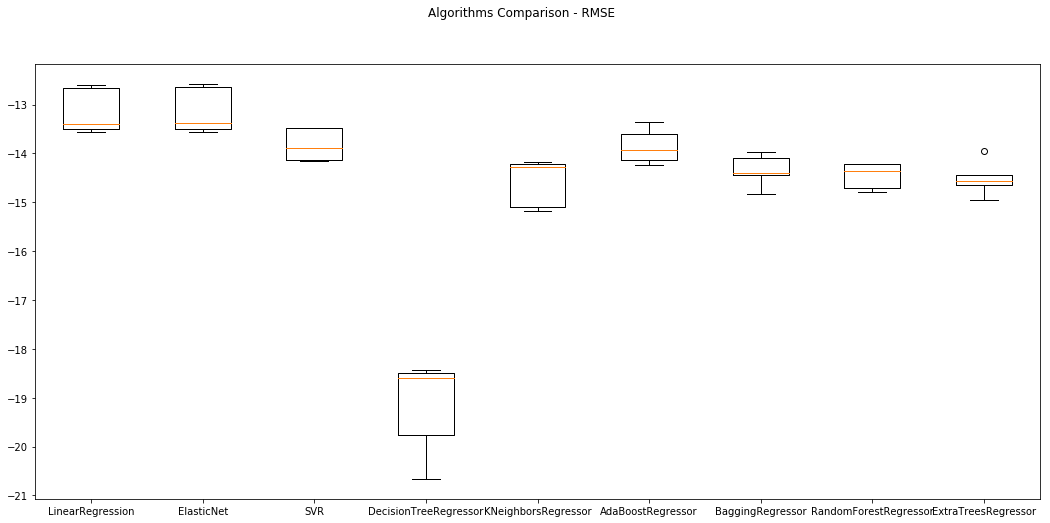

In [107]:
# Compare Algorithms
fig = plt.figure(figsize=(18, 8))
fig.suptitle('Algorithms Comparison - RMSE')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('images/ml_comparison_rmse_d.png')
plt.show();

---
<a id='model_d_tune'></a>

## Hyper-parameter Tuning

In [108]:
%%time
# LinearRegression
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1),
    "max_iter": [1, 10, 100, 1000],
    "fit_intercept": [True, False],
    "selection": ["cyclic", "random"]
}
model = models[1][1]

CPU times: user 16 µs, sys: 8 µs, total: 24 µs
Wall time: 25.7 µs


In [110]:
%%time
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Best: -13.126226564857761 using {'alpha': 1, 'fit_intercept': False, 'l1_ratio': 0.7000000000000001, 'max_iter': 10, 'selection': 'random'}
CPU times: user 2min 20s, sys: 19.7 s, total: 2min 40s
Wall time: 41.4 s


In [ ]:
Best: -13.126226564857761 using {'alpha': 1, 'fit_intercept': False, 'l1_ratio': 0.7000000000000001, 'max_iter': 10, 'selection': 'random'}
CPU times: user 2min 20s, sys: 19.7 s, total: 2min 40s
Wall time: 41.4 s

In [111]:
%%time
# ElasticNet
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": np.arange(0.0, 1.0, 0.1),
    "max_iter": [1, 10, 100, 1000],
    "fit_intercept": [True, False],
    "selection": ["cyclic", "random"]
}
model = models[1][1]

CPU times: user 18 µs, sys: 2 µs, total: 20 µs
Wall time: 21.7 µs


In [112]:
%%time
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Best: -13.12422705933348 using {'alpha': 1, 'fit_intercept': False, 'l1_ratio': 0.6000000000000001, 'max_iter': 10, 'selection': 'random'}
CPU times: user 2min 31s, sys: 22.5 s, total: 2min 53s
Wall time: 46.1 s


In [ ]:
Best: -13.12422705933348 using {'alpha': 1, 'fit_intercept': False, 'l1_ratio': 0.6000000000000001, 'max_iter': 10, 'selection': 'random'}
CPU times: user 2min 31s, sys: 22.5 s, total: 2min 53s
Wall time: 46.1 s

In [117]:
%%time
#SVR
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
# Epsilon-Support Vector Regression. 
# The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.
# The model produced by support vector classification (as described above) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target.
param_grid = {
    "kernel": ["linear", "rbf"],#, "poly", "sigmoid"], 
    "degree": [3],#[1, 2, 3, 4],
    "C": [1.5, 10],
    #"gamma": ["scale", "auto"],
    'epsilon':[0.01, 0.1, 0.2, 0.3, 0.5]
}
model = models[2][1]

CPU times: user 17 µs, sys: 224 µs, total: 241 µs
Wall time: 507 µs


In [ ]:
%%time
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [118]:
%%time
#SVR  - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.2min finished


Best: -13.141117773500117 using {'kernel': 'linear', 'epsilon': 0.5, 'degree': 3, 'C': 10}
CPU times: user 3min 28s, sys: 1.08 s, total: 3min 29s
Wall time: 27min 44s


In [ ]:
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.2min finished
Best: -13.141117773500117 using {'kernel': 'linear', 'epsilon': 0.5, 'degree': 3, 'C': 10}
CPU times: user 3min 28s, sys: 1.08 s, total: 3min 29s
Wall time: 27min 44s

In [123]:
%%time
#AdaBoostRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor
# An AdaBoost [1] regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional 
# copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. 
# As such, subsequent regressors focus more on difficult cases.
# The base estimator from which the boosted ensemble is built. If None, then the base estimator is DecisionTreeRegressor(max_depth=3).
param_grid = {
    "base_estimator": [models[0][1]],
    "n_estimators": [100, 200, 500],#, 1000, 5000, 10000],
    "loss": ["linear", "square", "exponential"]
}
model = models[5][1]

CPU times: user 11 µs, sys: 45 µs, total: 56 µs
Wall time: 103 µs


In [124]:
%%time
#AdaBoostRegressor - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best: -13.376934994077676 using {'n_estimators': 200, 'loss': 'linear', 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
CPU times: user 328 ms, sys: 114 ms, total: 442 ms
Wall time: 2.15 s


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


In [ ]:
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Best: -13.376934994077676 using {'n_estimators': 200, 'loss': 'linear', 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
CPU times: user 328 ms, sys: 114 ms, total: 442 ms
Wall time: 2.15 s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished

In [125]:
%%time
#BaggingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
# https://www.programcreek.com/python/example/85938/sklearn.ensemble.BaggingRegressor
# A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.
# The base estimator to fit on random subsets of the dataset. If None, then the base estimator is a decision tree.
param_grid = {
    "base_estimator": [models[0][1]],
    "n_estimators": [100, 200, 500, 1000, 5000, 10000],
    "bootstrap": [True, False],
    "n_jobs": [-1]
}
model = models[6][1]

CPU times: user 7 µs, sys: 7 µs, total: 14 µs
Wall time: 16.9 µs


In [ ]:
%%time
perform_grid_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

In [126]:
%%time
#BaggingRegressor - Random Search
perform_random_search_cv2(X_train=X_train, 
                        y_train=y_train, 
                        model=model, 
                        param_grid=param_grid, 
                        scoring='neg_root_mean_squared_error', 
                        num_folds=6, 
                        seed=123)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s


Best: -13.141310202266377 using {'n_jobs': -1, 'n_estimators': 100, 'bootstrap': True, 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
CPU times: user 313 ms, sys: 30.2 ms, total: 343 ms
Wall time: 1min 45s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


In [ ]:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
Best: -13.141310202266377 using {'n_jobs': -1, 'n_estimators': 100, 'bootstrap': True, 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
CPU times: user 313 ms, sys: 30.2 ms, total: 343 ms
Wall time: 1min 45s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished

### Evaluate best models on test dataset

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

In [130]:
best_models = [
    LinearRegression({'alpha': 1, 'fit_intercept': False, 'l1_ratio': 0.7000000000000001, 'max_iter': 10, 'selection': 'random'}),
    ElasticNet(**{'alpha': 1, 'fit_intercept': False, 'l1_ratio': 0.6000000000000001, 'max_iter': 10, 'selection': 'random'}),
    SVR(**{'kernel': 'linear', 'epsilon': 0.5, 'degree': 3, 'C': 10}),
    AdaBoostRegressor(**{'n_estimators': 200, 'loss': 'linear', 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}),
    BaggingRegressor(**{'n_jobs': -1, 'n_estimators': 100, 'bootstrap': True, 'base_estimator': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)})
]

models = []

for model in best_models:
    item = (type(model).__name__, model)
    models.append(item)
    print(item)

('LinearRegression', LinearRegression(copy_X=True,
                 fit_intercept={'alpha': 1, 'fit_intercept': False,
                                'l1_ratio': 0.7000000000000001, 'max_iter': 10,
                                'selection': 'random'},
                 n_jobs=None, normalize=False))
('ElasticNet', ElasticNet(alpha=1, copy_X=True, fit_intercept=False,
           l1_ratio=0.6000000000000001, max_iter=10, normalize=False,
           positive=False, precompute=False, random_state=None,
           selection='random', tol=0.0001, warm_start=False))
('SVR', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))
('AdaBoostRegressor', AdaBoostRegressor(base_estimator=LinearRegression(copy_X=True,
                                                  fit_intercept=True,
                                                  n_jobs=None,
                                                  norm

In [131]:
scores, results, names = score_ml_models(X_train=X_test,
                                         y_train=y_test,
                                         models=models,
                                         n_splits = 5,
                                         metric='neg_root_mean_squared_error',
                                         metric_label="RMSE", 
                                         seed=123)

for score in scores:
    print(score)

LinearRegression, RMSE 13.048955489499978, (std. dev. 1.579505939681471)
ElasticNet, RMSE 11.967137144731709, (std. dev. 1.209049991528524)
SVR, RMSE 11.798205904606231, (std. dev. 1.5691210883592683)
AdaBoostRegressor, RMSE 14.214767389976393, (std. dev. 1.5669097096940707)
BaggingRegressor, RMSE 12.913849222119717, (std. dev. 1.5620223443945112)


In [ ]:
LinearRegression, RMSE 13.048955489499978, (std. dev. 1.579505939681471)
ElasticNet, RMSE 11.967137144731709, (std. dev. 1.209049991528524)
SVR, RMSE 11.798205904606231, (std. dev. 1.5691210883592683)
AdaBoostRegressor, RMSE 14.214767389976393, (std. dev. 1.5669097096940707)
BaggingRegressor, RMSE 12.913849222119717, (std. dev. 1.5620223443945112)

## Model persistence

In [ ]:
from joblib import dump, load
dump(model, 'model.joblib') 
model2 = load('model.joblib')
model2.predict(X[0:20])